# Data Description:
We are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## Files
train.csv - historical data including Sales,
test.csv - historical data excluding Sales,
sample_submission.csv - a sample submission file in the correct format,
store.csv - supplemental information about the stores.

## Problem Statement:
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. We need to predict sales based on their unique circumstances.

## Data fields:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import math
import seaborn as sns
from pandasql import sqldf
import matplotlib.pyplot as plt
#for removing warnings
import warnings
warnings.filterwarnings('ignore')
from keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# Reading files
train=pd.read_csv("train.csv")
print(train.shape)
train.head()

(1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
test=pd.read_csv("test.csv")
print(test.shape)
test.head()

(41088, 8)


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [4]:
store_df=pd.read_csv("store.csv")
print(store_df.shape)
store_df.head()

(1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Checking for null values

In [5]:
train.info() # no null values in train data
print("----------------------------------------------")
test.info() #few null values in open

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfW

#### Train Data Analysis

In [6]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [7]:
train['Date'] = pd.to_datetime(train['Date'])

<AxesSubplot:xlabel='Open', ylabel='count'>

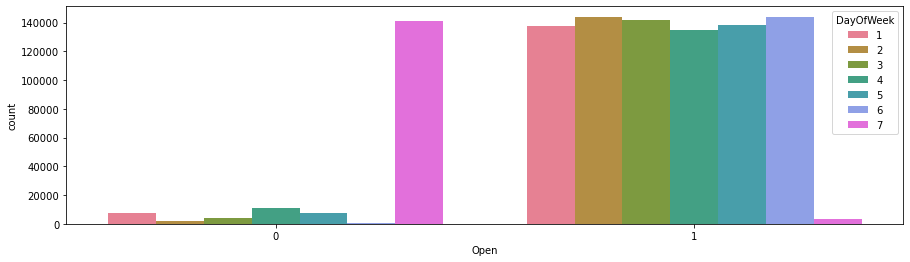

In [8]:
fig, ax1 = plt.subplots(figsize=(15,4))
sns.countplot(x='Open',hue='DayOfWeek', data=train,palette="husl", ax=ax1)

Many stores are closed on Sundays 

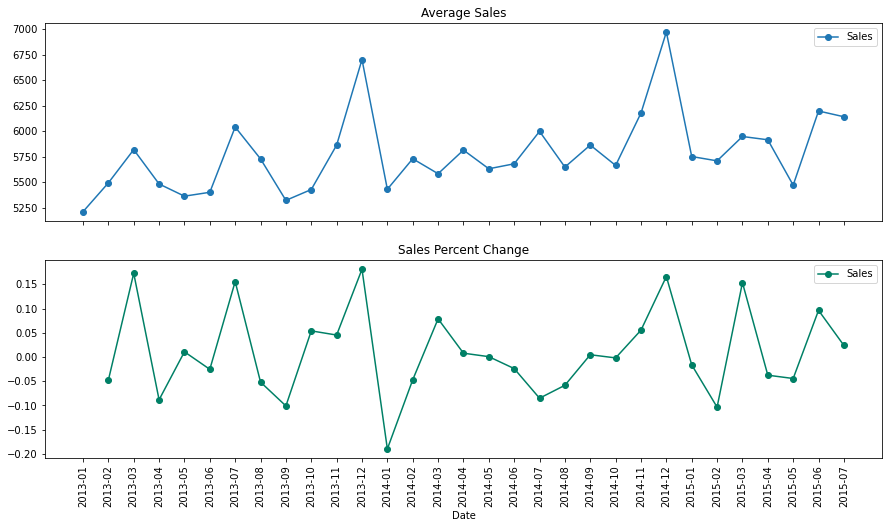

In [9]:
# Date

# Create Year and Month columns
train['Year']  = train['Date'].apply(lambda x: int(str(x)[:4]))
train['Month'] = train['Date'].apply(lambda x: int(str(x)[5:7]))

test['Year']  = test['Date'].apply(lambda x: int(str(x)[:4]))
test['Month'] = test['Date'].apply(lambda x: int(str(x)[5:7]))

# Assign Date column to Date(Year-Month) instead of (Year-Month-Day)
train['Date'] = train['Date'].apply(lambda x: (str(x)[:7]))
test['Date']  = test['Date'].apply(lambda x: (str(x)[:7]))

# group by date and get average sales, and percent change
avg_sales   = train.groupby('Date')["Sales"].mean()
pct_change_sales = train.groupby('Date')["Sales"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average sales over time(year-month)
ax1 = avg_sales.plot(legend=True,ax=axis1,marker='o',title="Average Sales")
ax1.set_xticks(range(len(avg_sales)))
ax1.set_xticklabels(avg_sales.index.tolist(), rotation=90)

# plot precent change for sales over time(year-month)
ax2 = pct_change_sales.plot(legend=True,ax=axis2,marker='o',rot=90,colormap="summer",title="Sales Percent Change")

We can see that sales during december are at peak

<AxesSubplot:xlabel='Year', ylabel='Customers'>

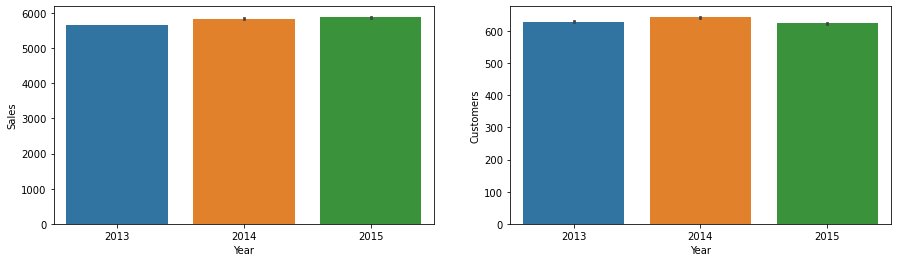

In [10]:
# Plot average sales and customers over years
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Year', y='Sales', data=train, ax=axis1)
sns.barplot(x='Year', y='Customers', data=train, ax=axis2)

<AxesSubplot:xlabel='DayOfWeek', ylabel='Customers'>

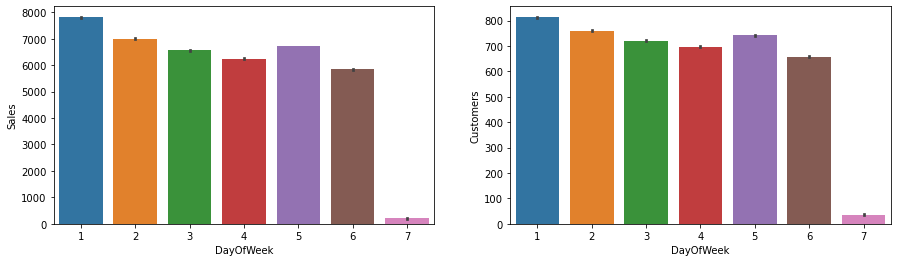

In [11]:
# Plot average sales and customers over days of week
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='DayOfWeek', y='Sales', data=train, ax=axis1)
sns.barplot(x='DayOfWeek', y='Customers', data=train, ax=axis2) 

Sales and Customers on Sunday are lowest as many stores are closed 

<AxesSubplot:xlabel='Month', ylabel='Customers'>

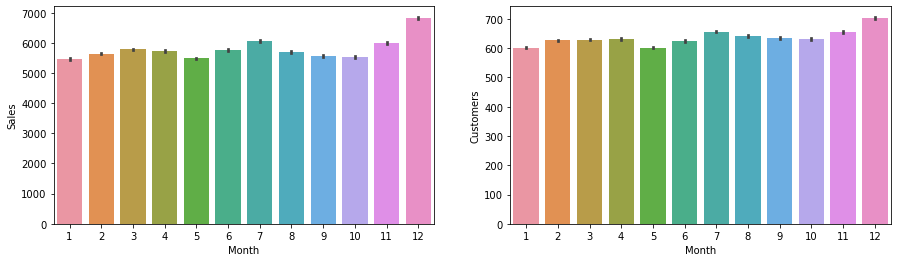

In [12]:
# Plot average sales and customers over months
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Month', y='Sales', data=train, ax=axis1)
sns.barplot(x='Month', y='Customers', data=train, ax=axis2)

Sales and Customers are comparatively higher in December as compared to other months

<AxesSubplot:xlabel='Promo', ylabel='Customers'>

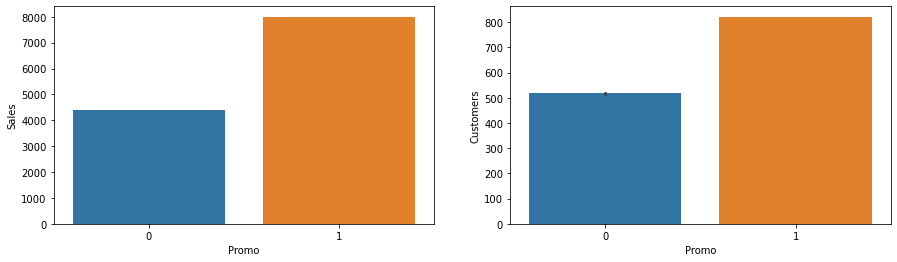

In [13]:
# Plot average sales and customers with/without promo
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Promo', y='Sales', data=train, ax=axis1)
sns.barplot(x='Promo', y='Customers', data=train, ax=axis2)

We can clearly see without promo the store doesn't stand a chance against stores with promo

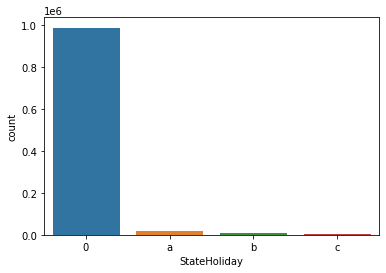

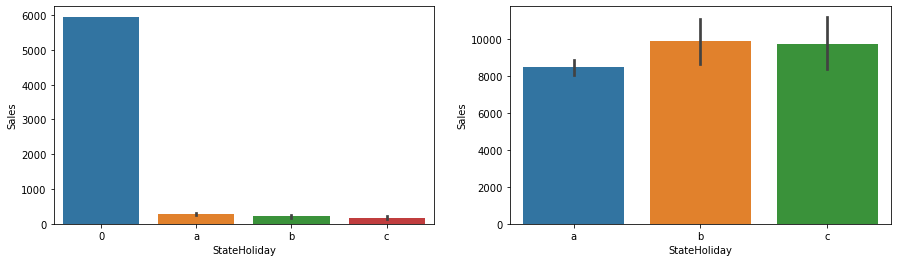

In [14]:
# StateHoliday has values 0 & "0", So, we need to merge values with 0 to "0"
train["StateHoliday"]= train["StateHoliday"].replace(0, "0")

sns.countplot(x='StateHoliday',data=train)

# Plot average sales on StateHoliday
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StateHoliday', y='Sales', data=train, ax=axis1)
filt = (train["StateHoliday"] != "0") & (train["Sales"] > 0) # we are taking sales which are more than 0
sns.barplot(x='StateHoliday', y='Sales', data=train[filt], ax=axis2)
plt.show()

Text(0.5, 1.0, 'Average Sales of stores which are open')

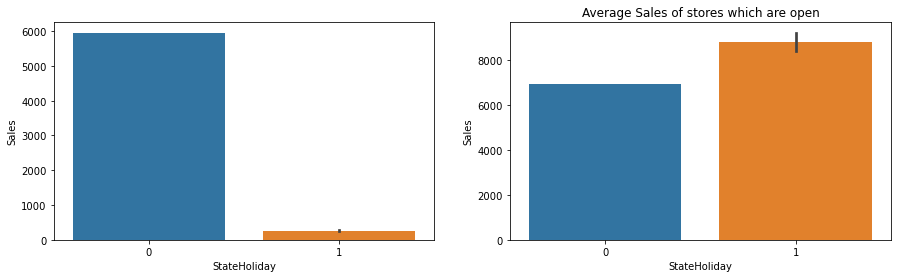

In [15]:
# Combining a,b and c type stores so as to reduce the bias
train["StateHoliday"] = train["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
test["StateHoliday"] = test["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
plt.title('All Sales of stores')
sns.barplot(x='StateHoliday', y='Sales', data=train, ax=axis1)
filt = (train["Sales"] > 0) # we are taking sales which are more than 0
sns.barplot(x='StateHoliday', y='Sales', data=train[filt], ax=axis2)
plt.title('Average Sales of stores which are open')

From the above graphs we can clearly see that the stores which are 'OPEN' during stateholidays have high sales

<AxesSubplot:xlabel='SchoolHoliday', ylabel='Customers'>

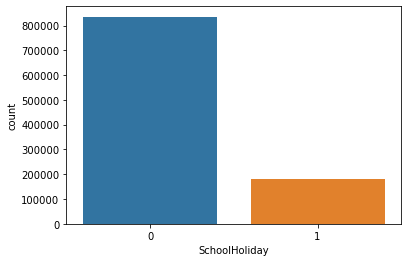

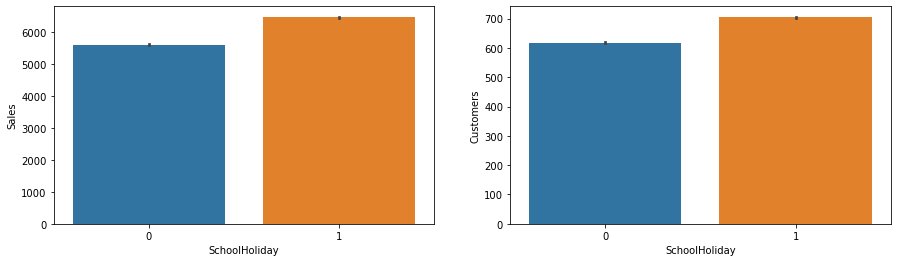

In [16]:
# Visualizing Sales over SchoolHoliday
sns.countplot(x='SchoolHoliday',data=train)

# Plot average sales on StateHoliday
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='SchoolHoliday', y='Sales', data=train, ax=axis1)

sns.barplot(x='SchoolHoliday', y='Customers', data=train, ax=axis2)

We can clearly see that the sales & customers during School Holiday are more compared to normal days

<AxesSubplot:ylabel='Frequency'>

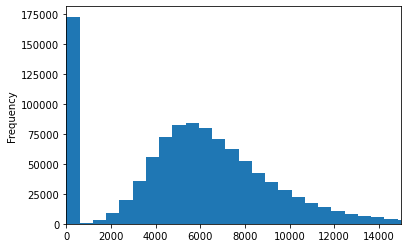

In [17]:
train["Sales"].plot(kind='hist',bins=70,xlim=(0,15000))

There are mostly 0's in this plot because the stores were closed

STORE DATA

In [18]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [19]:
store_df.info() # many null values
print("----------------------------------------------")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
----------------------------------------------


In [20]:
store_df['PromoInterval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

### Data Preprocessing

In [21]:
# Merging train and store_df
train_store = train.merge(store_df,left_on=['Store'], right_on=['Store'],how='left')
print(train_store.shape)
train_store.head()

(1017209, 20)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07,5263,555,1,1,0,1,2015,7,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07,6064,625,1,1,0,1,2015,7,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07,8314,821,1,1,0,1,2015,7,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07,13995,1498,1,1,0,1,2015,7,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07,4822,559,1,1,0,1,2015,7,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [22]:
test_store = test.merge(store_df,left_on=['Store'], right_on=['Store'],how='left')
print(test_store.shape)
test_store.head()

(41088, 19)


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09,1.0,1,0,0,2015,9,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09,1.0,1,0,0,2015,9,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09,1.0,1,0,0,2015,9,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09,1.0,1,0,0,2015,9,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09,1.0,1,0,0,2015,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [23]:
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  int64  
 8   SchoolHoliday              1017209 non-null  int64  
 9   Year                       1017209 non-null  int64  
 10  Month                      1017209 non-null  int64  
 11  StoreType                  1017209 non-null  object 
 12  Assortment                 1017209 non-null  object 
 13  CompetitionD

In [24]:
test_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  int64  
 7   SchoolHoliday              41088 non-null  int64  
 8   Year                       41088 non-null  int64  
 9   Month                      41088 non-null  int64  
 10  StoreType                  41088 non-null  object 
 11  Assortment                 41088 non-null  object 
 12  CompetitionDistance        40992 non-null  float64
 13  CompetitionOpenSinceMonth  25872 non-null  flo

<AxesSubplot:>

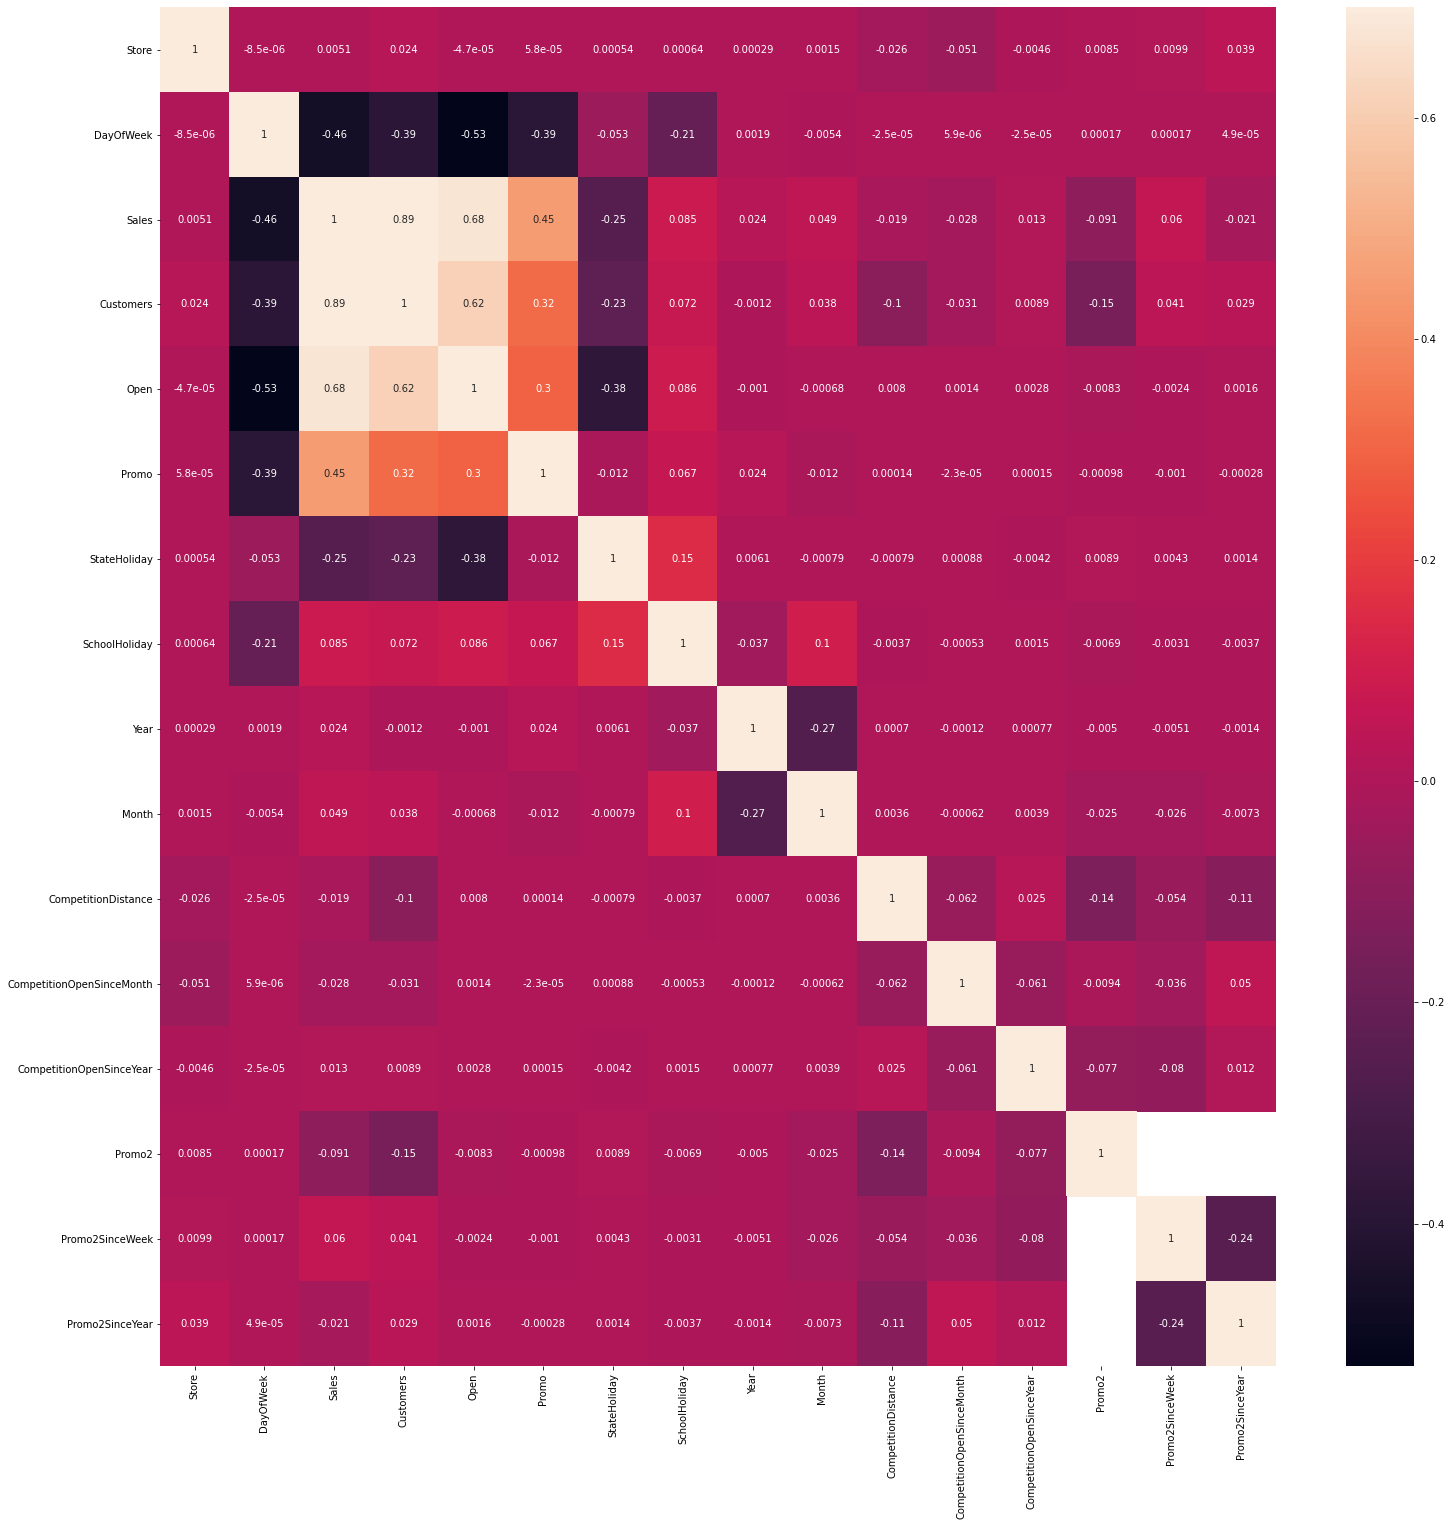

In [25]:
# Checking correlation bw different variables
plt.figure(figsize=(25,25))
sns.heatmap(train_store.corr(),vmax=.7,cbar=True,annot=True)

The highly correlated features with the target variable(Sales) are :- Promo, Open, Customers, DayOfWeek

**Treating Missing Values**

In [26]:
train_store.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
Year                              0
Month                             0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

<AxesSubplot:title={'center':'Promo2SinceYear'}, xlabel='Promo2SinceYear'>

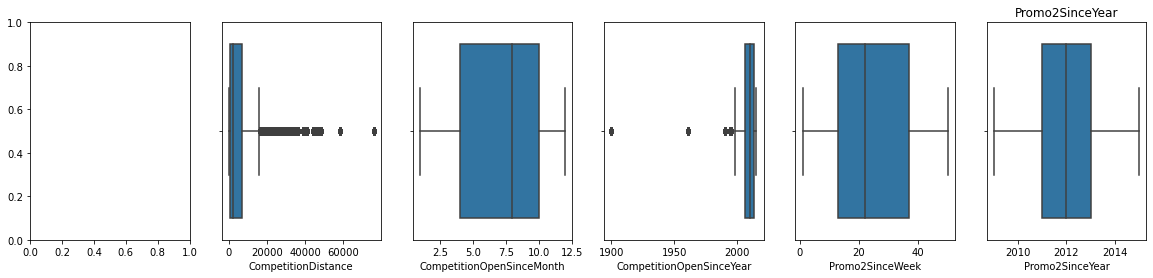

In [27]:
# Plot average sales on StateHoliday
fig, (axis1,axis2,axis3,axis4,axis5,axis6) = plt.subplots(1,6,figsize=(20,4))
plt.title('CompetitionDistance')
sns.boxplot( train_store['CompetitionDistance'],ax=axis2)
plt.title('CompetitionOpenSinceMonth')
sns.boxplot( train_store['CompetitionOpenSinceMonth'], ax=axis3)
plt.title('CompetitionOpenSinceYear')
sns.boxplot( train_store['CompetitionOpenSinceYear'], ax=axis4)
plt.title('Promo2SinceWeek')
sns.boxplot( train_store['Promo2SinceWeek'], ax=axis5)
plt.title('Promo2SinceYear')
sns.boxplot( train_store['Promo2SinceYear'], ax=axis6)

You can see there are lot of outliers

In [28]:
# Week of year and calculating promo
train_store['WeekOfYear'] = pd.DatetimeIndex(train_store['Date']).weekofyear
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0
train_store['PromoOpen'] = train_store.PromoOpen.apply(lambda x: x if x > 0 else 0)
train_store.loc[train_store.Promo2SinceYear == 0, 'PromoOpen'] = 0

In [29]:
test_store['WeekOfYear'] = pd.DatetimeIndex(test_store['Date']).weekofyear
test_store['PromoOpen'] = 12 * (test_store.Year - test_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - test_store.Promo2SinceWeek) / 4.0
test_store['PromoOpen'] = test_store.PromoOpen.apply(lambda x: x if x > 0 else 0)
test_store.loc[test_store.Promo2SinceYear == 0, 'PromoOpen'] = 0

In [30]:
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + (train_store.Month - train_store.CompetitionOpenSinceMonth)
test_store['CompetitionOpen'] = 12 * (test_store.Year - train_store.CompetitionOpenSinceYear) + (test_store.Month - test_store.CompetitionOpenSinceMonth)

In [31]:
#Replacing null values with median
med_comp_month = train_store['PromoOpen'].astype('float').median(axis=0)
train_store['PromoOpen'].replace(np.nan,math.floor(med_comp_month),inplace=True)

med_comp_month = train_store['PromoOpen'].astype('float').median(axis=0)
test_store['PromoOpen'].replace(np.nan,math.floor(med_comp_month),inplace=True)

med_comp_month = train_store['CompetitionOpen'].astype('float').median(axis=0)
train_store['CompetitionOpen'].replace(np.nan,math.floor(med_comp_month),inplace=True)

med_comp_month = train_store['CompetitionOpen'].astype('float').median(axis=0)
test_store['CompetitionOpen'].replace(np.nan,math.floor(med_comp_month),inplace=True)

I am replacing with Median (instead of mean due to outliers) as they are not highly correlated to the dependent variable

In [32]:
train_store.isnull().sum() # no null values

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
Year                              0
Month                             0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
WeekOfYear                        0
PromoOpen                         0
CompetitionOpen                   0
dtype: int64

#### Train and Store data Analysis

<AxesSubplot:xlabel='StoreType', ylabel='count'>

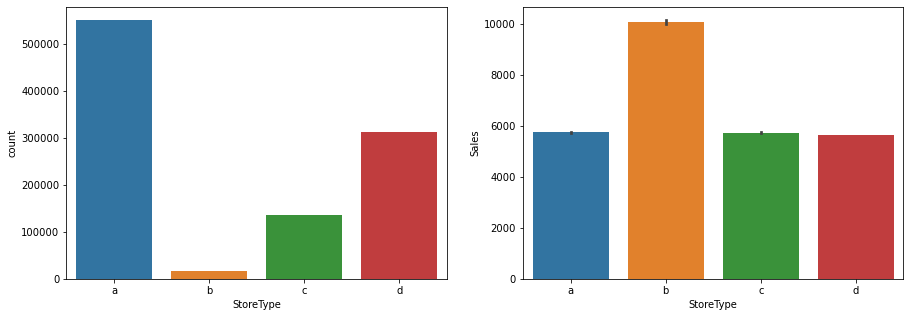

In [33]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))

#plt.title('StoreType vs Sales')
sns.barplot(x='StoreType', y='Sales', data=train_store, order=['a','b','c', 'd'],ax=axis2)
sns.countplot(x='StoreType',data=train_store, order=['a','b','c', 'd'],ax=axis1)
#plt.title('StoreType vs Customers')
#sns.barplot(x='StoreType', y='Customers', data=train_store, order=['a','b','c', 'd'], ax=axis2)

You can see that the 'b-type' stores are less but have high sales and volume, while 'a-type' stores are high in number but have relatively low sales and volume 

<AxesSubplot:xlabel='Assortment', ylabel='Sales'>

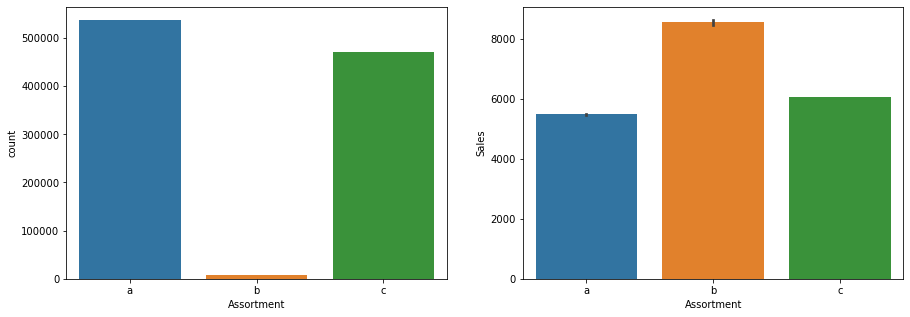

In [34]:
#plt.title('Assortment')
#sns.countplot(x='Assortment', data=train_store, order=['a','b','c'], ax=axis1)
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
#plt.title('Assortment vs Sales')
sns.countplot(x='Assortment', data=train_store, order=['a','b','c'], ax=axis1)
sns.barplot(x='Assortment', y='Sales', data=train_store, order=['a','b','c'], ax=axis2)
#plt.title('Assortment vs Customers')
#sns.barplot(x='Assortment', y='Customers', data=train_store, order=['a','b','c'], ax=axis2)

<AxesSubplot:title={'center':'Promo2 vs Customers'}, xlabel='Promo2', ylabel='Customers'>

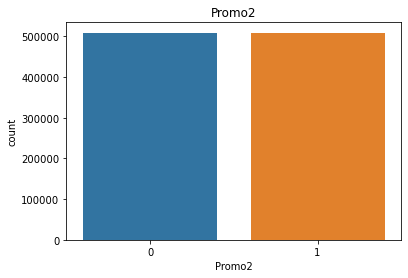

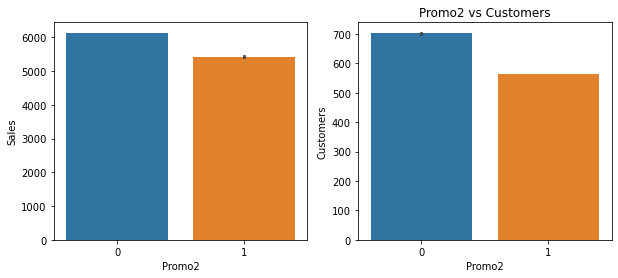

In [35]:
plt.title('Promo2')
sns.countplot(x='Promo2', data=train_store)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,4))

plt.title('Promo2 vs Sales')
sns.barplot(x='Promo2', y='Sales', data=train_store, ax=axis1)
plt.title('Promo2 vs Customers')
sns.barplot(x='Promo2', y='Customers', data=train_store, ax=axis2)

1.5986502899508919

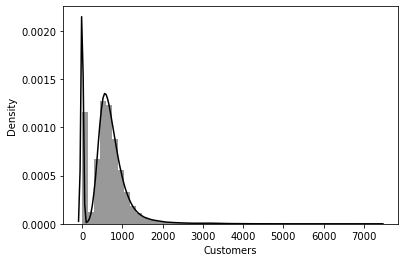

In [36]:
sns.distplot(train_store['Customers'],color='Black')
train_store['Customers'].skew()

0.6414596158103787

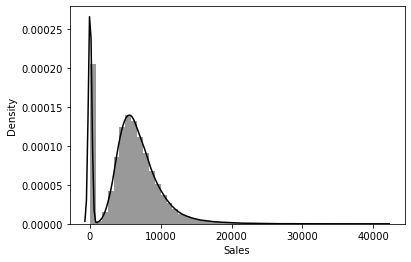

In [37]:
sns.distplot(train_store['Sales'],color='Black')
train_store['Sales'].skew()

Text(0.5, 1.0, 'Correlation Coefficients w.r.t Sales')

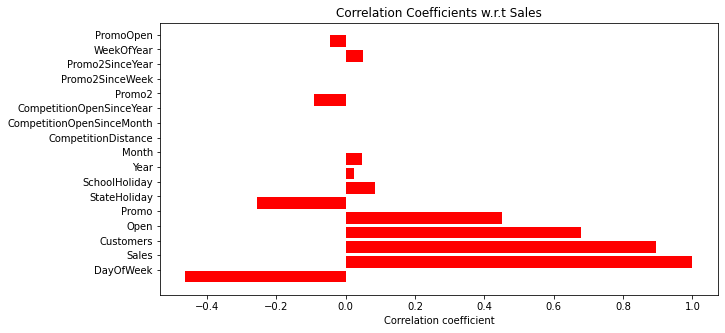

In [38]:
# Plotting correlations
num_feat=train_store.columns[train_store.dtypes!=object]
num_feat=num_feat[1:-1] 
labels = []
values = []
for col in num_feat:
    labels.append(col)
    values.append(np.corrcoef(train_store[col].values, train_store['Sales'].values)[0,1])
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(10,5))
rects = ax.barh(ind, np.array(values), color='red')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation Coefficients w.r.t Sales")

### Feature Engineering & Selection of Train and Test Data

In [39]:
train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,WeekOfYear,PromoOpen,CompetitionOpen
0,1,5,2015-07,5263,555,1,1,0,1,2015,...,1270.0,9.0,2008.0,0,NaN,NaN,NaN,27,0.00,82.0
1,2,5,2015-07,6064,625,1,1,0,1,2015,...,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",27,63.50,92.0
2,3,5,2015-07,8314,821,1,1,0,1,2015,...,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",27,51.25,103.0
3,4,5,2015-07,13995,1498,1,1,0,1,2015,...,620.0,9.0,2009.0,0,NaN,NaN,NaN,27,0.00,70.0
4,5,5,2015-07,4822,559,1,1,0,1,2015,...,29910.0,4.0,2015.0,0,NaN,NaN,NaN,27,0.00,3.0


In [40]:
# Creating new columns Average Customers and Sales Per Customerfrom pandasql import sqldf
avg_customer = sqldf(
      """
      SELECT
      Store,
      DayOfWeek,
      sum(case when Customers is not null then Sales/Customers else 0 end) as SpC,
      round(avg(Customers)) Avg_Customers
      from train_store
      group by Store,DayOfWeek
      """
    )
    
test_store = sqldf(
      """
      SELECT
      t.*,
      ac.SpC,
      ac.Avg_Customers
      from test_store t
      left join avg_customer ac on t.Store = ac.Store and t.DayOfWeek = ac.DayOfWeek
      """
    )
train_store = sqldf(
      """
      SELECT
      t.*,
      ac.SpC,
      ac.Avg_Customers
      from train_store t
      left join avg_customer ac on t.Store = ac.Store and t.DayOfWeek = ac.DayOfWeek
      """
    )

In [41]:
test_store.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,WeekOfYear,PromoOpen,CompetitionOpen,SpC,Avg_Customers
0,1,1,4,2015-09,1.0,1,0,0,2015,9,...,2008.0,0,NaN,NaN,None,36,0.00,84.0,965.0,493.0
1,2,3,4,2015-09,1.0,1,0,0,2015,9,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",36,51.25,93.0,1044.0,708.0
2,3,7,4,2015-09,1.0,1,0,0,2015,9,...,2013.0,0,NaN,NaN,None,36,0.00,113.0,1095.0,886.0
3,4,8,4,2015-09,1.0,1,0,0,2015,9,...,2014.0,0,NaN,NaN,None,36,0.00,71.0,940.0,751.0
4,5,9,4,2015-09,1.0,1,0,0,2015,9,...,2000.0,0,NaN,NaN,None,36,0.00,1.0,1307.0,508.0


In [42]:
train_store.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
Year                              0
Month                             0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
WeekOfYear                        0
PromoOpen                         0
CompetitionOpen                   0
SpC                          140334
Avg_Customers                     0
dtype: int64

In [43]:
# Create dummy varibales for DayOfWeek
train_dummies  = pd.get_dummies(train_store['DayOfWeek'], prefix='Day')
train_dummies.drop(['Day_7'], axis=1, inplace=True)

test_dummies = pd.get_dummies(test_store['DayOfWeek'],prefix='Day')
test_dummies.drop(['Day_7'], axis=1, inplace=True)

train_store = train_store.join(train_dummies)
test_store = test_store.join(test_dummies)

In [44]:
# Create dummy varibales for Assortment
train_store_dummies  = pd.get_dummies(train_store['Assortment'], prefix='Assortment')
train_store_dummies.drop(['Assortment_c'], axis=1, inplace=True)

test_store_dummies = pd.get_dummies(test_store['Assortment'],prefix='Assortment')
test_store_dummies.drop(['Assortment_c'], axis=1, inplace=True)

train_store = train_store.join(train_store_dummies)
test_store = test_store.join(test_store_dummies)

In [45]:
# Create dummy varibales for Storetype
train_store_dummies  = pd.get_dummies(train_store['StoreType'], prefix='StoreType')
train_store_dummies.drop(['StoreType_d'], axis=1, inplace=True)

test_store_dummies = pd.get_dummies(test_store['StoreType'],prefix='StoreType')
test_store_dummies.drop(['StoreType_d'], axis=1, inplace=True)

train_store = train_store.join(train_store_dummies)
test_store = test_store.join(test_store_dummies)

In [46]:
#Dropping unnecessary columns from train and test set
train_store.drop(['Customers','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','CompetitionDistance','Promo2SinceWeek','Promo2SinceYear','PromoInterval','WeekOfYear','Year','StoreType','Assortment','Date'],axis=1,inplace=True)
train_store['Open'] = train_store['Open'].astype(float)
test_store.drop(['Year','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','CompetitionDistance','Promo2SinceWeek','Promo2SinceYear','PromoInterval','Promo2SinceWeek','Promo2SinceYear','PromoInterval','WeekOfYear','WeekOfYear','StoreType','Assortment','Date'],axis=1,inplace=True)

In [47]:
print(train_store.info())
print(test_store.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 24 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Store            1017209 non-null  int64  
 1   DayOfWeek        1017209 non-null  int64  
 2   Sales            1017209 non-null  int64  
 3   Open             1017209 non-null  float64
 4   Promo            1017209 non-null  int64  
 5   StateHoliday     1017209 non-null  int64  
 6   SchoolHoliday    1017209 non-null  int64  
 7   Month            1017209 non-null  int64  
 8   Promo2           1017209 non-null  int64  
 9   PromoOpen        1017209 non-null  float64
 10  CompetitionOpen  1017209 non-null  float64
 11  SpC              876875 non-null   float64
 12  Avg_Customers    1017209 non-null  float64
 13  Day_1            1017209 non-null  uint8  
 14  Day_2            1017209 non-null  uint8  
 15  Day_3            1017209 non-null  uint8  
 16  Day_4            1

In [48]:
test_store[test_store['Open'].isnull()]

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Month,Promo2,PromoOpen,...,Day_2,Day_3,Day_4,Day_5,Day_6,Assortment_a,Assortment_b,StoreType_a,StoreType_b,StoreType_c
479,480,622,4,NaN,1,0,0,9,0,0.0,...,0,0,1,0,0,0,0,1,0,0
1335,1336,622,3,NaN,1,0,0,9,0,0.0,...,0,1,0,0,0,0,0,1,0,0
2191,2192,622,2,NaN,1,0,0,9,0,0.0,...,1,0,0,0,0,0,0,1,0,0
3047,3048,622,1,NaN,1,0,0,9,0,0.0,...,0,0,0,0,0,0,0,1,0,0
4759,4760,622,6,NaN,0,0,0,9,0,0.0,...,0,0,0,0,1,0,0,1,0,0
5615,5616,622,5,NaN,0,0,0,9,0,0.0,...,0,0,0,1,0,0,0,1,0,0
6471,6472,622,4,NaN,0,0,0,9,0,0.0,...,0,0,1,0,0,0,0,1,0,0
7327,7328,622,3,NaN,0,0,0,9,0,0.0,...,0,1,0,0,0,0,0,1,0,0
8183,8184,622,2,NaN,0,0,0,9,0,0.0,...,1,0,0,0,0,0,0,1,0,0
9039,9040,622,1,NaN,0,0,0,9,0,0.0,...,0,0,0,0,0,0,0,1,0,0


As you can see all the null values of open are when week is not 7 and StateHoliday and SchoolHoliday are 0's. So replacing them with 1's

In [49]:
# fill NaN values in test with Open=1
test_store["Open"].fillna(1, inplace = True) 

In [50]:
# Dropping DayOfWeek
train_store.drop(['DayOfWeek'], axis=1,inplace=True)
test_store.drop(['DayOfWeek'], axis=1,inplace=True)

removing all rows(stores) that were closed as the sales are 0 when store is closed and it tend to make the model unstable

In [51]:
# remove all rows(store,date) that were closed
train_store= train_store[train_store["Open"] != 0]

Saving id's of those stores which were closed so we can put 0 in their respective sales column

In [52]:
# Saving id's of those stores which were closed so we can put 0 in their respective sales column
closed_ids = test_store["Id"][test["Open"] == 0].values
print(closed_ids.shape)
closed_ids

(5984,)


array([  544,   677,   841, ..., 40230, 40231, 40232], dtype=int64)

In [53]:
# remove all rows(store,date) that were closed
test_store = test_store[test_store["Open"] != 0]

In [54]:
test_store = test_store.reset_index()

In [55]:
test_store.drop(["index"],axis =1, inplace= True)

In [56]:
# define training and testing sets
train = train_store.drop(["Store","Open"],axis=1)

In [57]:
test = test_store.drop(["Id","Store","Open"],axis=1)

In [58]:
def load_train_data(scaler_x, scaler_y):
    '''
    Transform train data set and separate a test dataset to validate the model in the end of training and normalize data
    '''
    X_train = train.drop(["Sales"], axis=1) # Features
    y_train = np.array(train["Sales"]).reshape((len(X_train), 1)) # Targets
    X_train = scaler_x.fit_transform(X_train)
    y_train = scaler_y.fit_transform(y_train)

    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

    return (X_train, y_train), (X_test, y_test)

In [59]:
def load_test_data():
    '''
    Remove column of predictions and normalize data of submission test data set.
    '''
    X_test = test # Features
    X_test = StandardScaler().fit_transform(X_test)

    return X_test

WOW! That took a lot of time, but we finally have clean and perfect data that we want. Now to the model building part.

### Model Building

### Neural Network

In [60]:
def rmspe_val(y_true, y_pred):
    '''
    RMSPE calculus to validate evaluation metric about the model
    '''
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true), axis=0))[0]
def rmse(y_true, y_pred):
    '''
    RMSE calculus to use during training phase
    '''
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [61]:
def rmspe(y_true, y_pred):
    '''
    RMSPE calculus to use during training phase
    '''
    return K.sqrt(K.mean(K.square((y_true - y_pred) / y_true), axis=-1))

In [62]:
# We took Relu activation function as it is from 0 to infinity
def create_model():
    '''
    Create a neural network
    '''
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation="relu", kernel_initializer='normal'))
    model.add(Dropout(0.2)) # We are dropping a few neurons for generalizing the model
    model.add(Dense(32, input_dim=X_train.shape[1], activation="relu", kernel_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(32, input_dim=X_train.shape[1], activation="relu", kernel_initializer='normal'))
    model.add(Dropout(0.2)) 
    model.add(Dense(1, activation="linear", kernel_initializer='normal'))
    adam = Adam(lr=1e-3, decay=1e-3)

    # Compile model
    model.compile(loss="mean_squared_error", optimizer=adam, metrics=[rmse, rmspe])

    return model

In [63]:
# Hyperparameters and load data to train the model
batch_size = 32
nb_epoch = 100

scaler_x = StandardScaler()
scaler_y = StandardScaler()

print('Loading data...')
(X_train, y_train), (X_test, y_test) = load_train_data(scaler_x, scaler_y)

print('Build model...')
model = create_model()
model.summary()

Loading data...
Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                672       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)          

In [64]:
print('Fit model...')
filepath="weights_rossmann.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
callbacks_list = [checkpoint, early_stopping]

log = model.fit(X_train, y_train,
          validation_split=0.20, batch_size=batch_size, epochs=nb_epoch, shuffle=True, callbacks=callbacks_list)

Fit model...
Epoch 1/100
16872/16888 [============================>.] - ETA: 0s - loss: 0.2317 - rmse: 0.4648 - rmspe: 2.5011
Epoch 00001: val_loss improved from inf to 0.17986, saving model to weights_rossmann.best.hdf5
16888/16888 [==============================] - 21s 1ms/step - loss: 0.2317 - rmse: 0.4648 - rmspe: 2.5003 - val_loss: 0.1799 - val_rmse: 0.4099 - val_rmspe: 2.2664
Epoch 2/100
16876/16888 [============================>.] - ETA: 0s - loss: 0.2160 - rmse: 0.4502 - rmspe: 2.4485
Epoch 00002: val_loss improved from 0.17986 to 0.17691, saving model to weights_rossmann.best.hdf5
16888/16888 [==============================] - 27s 2ms/step - loss: 0.2159 - rmse: 0.4501 - rmspe: 2.4475 - val_loss: 0.1769 - val_rmse: 0.4065 - val_rmspe: 2.2578
Epoch 3/100
16864/16888 [============================>.] - ETA: 0s - loss: 0.2122 - rmse: 0.4462 - rmspe: 2.4390
Epoch 00003: val_loss improved from 0.17691 to 0.17509, saving model to weights_rossmann.best.hdf5
16888/16888 [==============

16851/16888 [============================>.] - ETA: 0s - loss: 0.2034 - rmse: 0.4369 - rmspe: 2.4297
Epoch 00023: val_loss did not improve from 0.16600
16888/16888 [==============================] - 27s 2ms/step - loss: 0.2033 - rmse: 0.4369 - rmspe: 2.4374 - val_loss: 0.1660 - val_rmse: 0.3939 - val_rmspe: 2.2068
Epoch 24/100
16881/16888 [============================>.] - ETA: 0s - loss: 0.2036 - rmse: 0.4372 - rmspe: 2.4280
Epoch 00024: val_loss did not improve from 0.16600
16888/16888 [==============================] - 28s 2ms/step - loss: 0.2036 - rmse: 0.4372 - rmspe: 2.4277 - val_loss: 0.1660 - val_rmse: 0.3938 - val_rmspe: 2.1982
Epoch 25/100
16876/16888 [============================>.] - ETA: 0s - loss: 0.2036 - rmse: 0.4372 - rmspe: 2.4376
Epoch 00025: val_loss improved from 0.16600 to 0.16570, saving model to weights_rossmann.best.hdf5
16888/16888 [==============================] - 27s 2ms/step - loss: 0.2036 - rmse: 0.4372 - rmspe: 2.4374 - val_loss: 0.1657 - val_rmse: 0.393

Epoch 46/100
16857/16888 [============================>.] - ETA: 0s - loss: 0.2021 - rmse: 0.4355 - rmspe: 2.4255 ETA: 0s - loss: 0.2022 - rmse: 0.43
Epoch 00046: val_loss improved from 0.16433 to 0.16427, saving model to weights_rossmann.best.hdf5
16888/16888 [==============================] - 22s 1ms/step - loss: 0.2021 - rmse: 0.4355 - rmspe: 2.4254 - val_loss: 0.1643 - val_rmse: 0.3918 - val_rmspe: 2.1942
Epoch 47/100
16854/16888 [============================>.] - ETA: 0s - loss: 0.2023 - rmse: 0.4355 - rmspe: 2.4112
Epoch 00047: val_loss did not improve from 0.16427
16888/16888 [==============================] - 22s 1ms/step - loss: 0.2023 - rmse: 0.4355 - rmspe: 2.4107 - val_loss: 0.1643 - val_rmse: 0.3918 - val_rmspe: 2.1926
Epoch 48/100
16880/16888 [============================>.] - ETA: 0s - loss: 0.2016 - rmse: 0.4350 - rmspe: 2.4240
Epoch 00048: val_loss improved from 0.16427 to 0.16410, saving model to weights_rossmann.best.hdf5
16888/16888 [==============================] 

Epoch 69/100
16873/16888 [============================>.] - ETA: 0s - loss: 0.2004 - rmse: 0.4338 - rmspe: 2.4578
Epoch 00069: val_loss improved from 0.16338 to 0.16335, saving model to weights_rossmann.best.hdf5
16888/16888 [==============================] - 22s 1ms/step - loss: 0.2004 - rmse: 0.4338 - rmspe: 2.4567 - val_loss: 0.1634 - val_rmse: 0.3908 - val_rmspe: 2.1897
Epoch 70/100
16867/16888 [============================>.] - ETA: 0s - loss: 0.2007 - rmse: 0.4340 - rmspe: 2.4647
Epoch 00070: val_loss did not improve from 0.16335
16888/16888 [==============================] - 22s 1ms/step - loss: 0.2008 - rmse: 0.4340 - rmspe: 2.4711 - val_loss: 0.1634 - val_rmse: 0.3908 - val_rmspe: 2.1880
Epoch 71/100
16846/16888 [============================>.] - ETA: 0s - loss: 0.2020 - rmse: 0.4353 - rmspe: 2.4121
Epoch 00071: val_loss did not improve from 0.16335
16888/16888 [==============================] - 21s 1ms/step - loss: 0.2019 - rmse: 0.4352 - rmspe: 2.4097 - val_loss: 0.1634 - va

16857/16888 [============================>.] - ETA: 0s - loss: 0.2001 - rmse: 0.4333 - rmspe: 2.4584
Epoch 00092: val_loss did not improve from 0.16289
16888/16888 [==============================] - 21s 1ms/step - loss: 0.2001 - rmse: 0.4332 - rmspe: 2.4576 - val_loss: 0.1629 - val_rmse: 0.3902 - val_rmspe: 2.1847
Epoch 93/100
16866/16888 [============================>.] - ETA: 0s - loss: 0.2004 - rmse: 0.4337 - rmspe: 2.4477 ETA: 0s - loss: 0.2004 - rmse: 
Epoch 00093: val_loss did not improve from 0.16289
16888/16888 [==============================] - 21s 1ms/step - loss: 0.2003 - rmse: 0.4337 - rmspe: 2.4461 - val_loss: 0.1630 - val_rmse: 0.3903 - val_rmspe: 2.1828
Epoch 94/100
16888/16888 [==============================] - ETA: 0s - loss: 0.2003 - rmse: 0.4336 - rmspe: 2.3924
Epoch 00094: val_loss improved from 0.16289 to 0.16289, saving model to weights_rossmann.best.hdf5
16888/16888 [==============================] - 20s 1ms/step - loss: 0.2003 - rmse: 0.4336 - rmspe: 2.3924 - va

In [65]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def show_info(model, X, y, log, weights = None):
    '''
    Show metrics about the evaluation model and plots about loss, rmse and rmspe
    '''
    if (log != None):
        # summarize history for loss
        plt.figure(figsize=(14,10))
        plt.plot(log.history['loss'])
        plt.plot(log.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        print('\n')
        
        # summarize history for rmse
        plt.figure(figsize=(14,10))
        plt.plot(log.history['rmse'])
        plt.plot(log.history['val_rmse'])
        plt.title('Model RMSE')
        plt.ylabel('rmse')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        print('\n')
        
        # summarize history for rmspe
        plt.figure(figsize=(14,10))
        plt.plot(log.history['rmspe'])
        plt.plot(log.history['val_rmspe'])
        plt.title('Model RMSPE')
        plt.ylabel('rmspe')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    if (weights != None):
        model.load_weights(weights)

    predictions = model.predict(X, verbose=1)

    mse = mean_squared_error(y, predictions)
    rmse = sqrt(mse)
    rmspe = rmspe_val(y, predictions)

    print('MSE: %.3f' % mse)
    print('RMSE: %.3f' % rmse)
    print('RMSPE: %.3f' % rmspe)

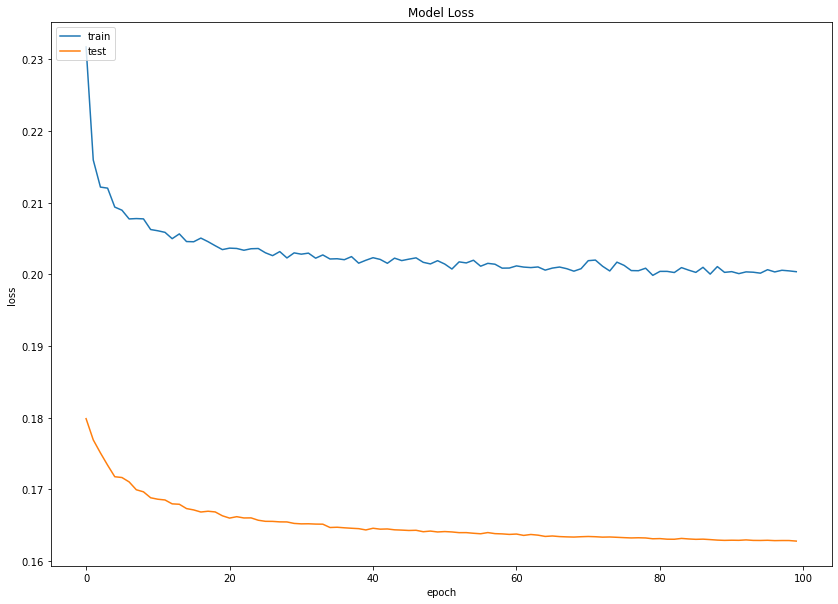

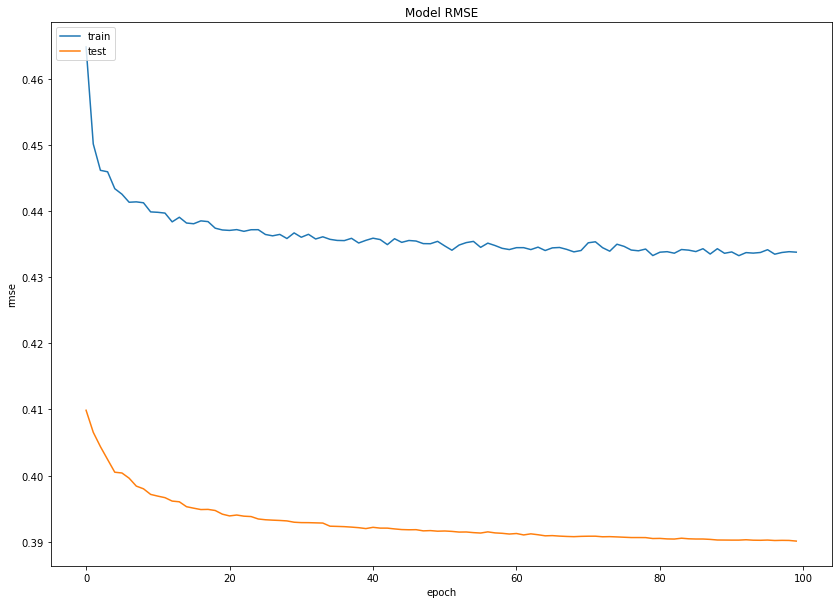

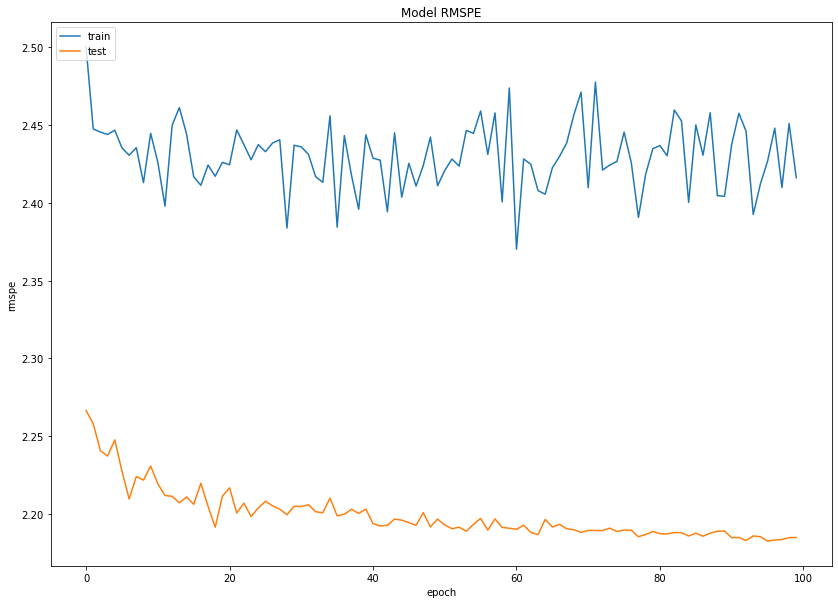

5278/5278 [==============================] - 3s 486us/step
MSE: 0.164
RMSE: 0.404
RMSPE: 35.731


In [66]:
show_info(model, X_test, y_test, log, weights='weights_rossmann.best.hdf5')

In [67]:
test_data = load_test_data()
predict = model.predict(test_data)
predict = scaler_y.inverse_transform(predict)

In [68]:
pred=pd.DataFrame(predict,columns = ['Sales'])
submission = pd.concat([test_store['Id'],pred],axis=1)
# Creating closed stores dataframe
Closed_Stores = pd.DataFrame(closed_ids,columns = ['Id'])
print(Closed_Stores.shape)
Closed_Stores['Sales'] = 0
submission = submission.append(Closed_Stores)
# Converting it to csv
submission.to_csv('submission.csv', index=False)

(5984, 1)


#### We submitted and got an error of 0.18